In [1]:
!nvidia-smi

Thu Jun  6 20:01:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB-LS        Off | 00000000:06:00.0 Off |                    0 |
| N/A   37C    P0              47W / 163W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys
sys.path.append(f'/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/mae')

In [3]:
import models_lib
import torchvision.transforms as transforms
import torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from dataset_mae import MAEDataset


In [4]:
MEAN_CLIPORT = [0.48145466, 0.4578275, 0.40821073]
STD_CLIPORT = [0.26862954, 0.26130258, 0.27577711]
TEST_PATH = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/data_hdf5/exist_dataset_no_aug_all_test.hdf5'
MODEL = 'mae_robot_lang'
CHECKPOINT = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/output_mae_robot_lang_big/checkpoint-160.pth'
device = 'cuda'

In [5]:
def get_fix_transform():
    trasform_fix = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_CLIPORT, std=STD_CLIPORT)])
    return trasform_fix

def generate_token(text_processor, lang, device):
    if type(lang) is str:
        decoded_strings = [lang]
    else:
        decoded_strings = [s.decode('ascii') for s in lang]
    processed_lang = text_processor(text=decoded_strings, padding="max_length", return_tensors='pt')
    processed_lang = processed_lang.to(device)
    return processed_lang

In [17]:
# load data and model
transform_train = get_fix_transform()
dataset_vis = MAEDataset(transform=transform_train, data_path=TEST_PATH)
model = models_lib.__dict__[MODEL](norm_pix_loss=False)
model.to(device)
checkpoint = torch.load(CHECKPOINT, map_location='cpu')
model.load_state_dict(checkpoint['model'])

Length of the dataset:  8633


<All keys matched successfully>

In [7]:
from transformers import AutoTokenizer
text_processor = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [11]:
from torch.utils.data import DataLoader, Subset
def get_random_batch(idx):
    subset_indices = [idx]
    subset = Subset(dataset_vis, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)
    batch = next(iter(subset_loader))
    return batch

In [12]:
TESTSET_IDX = [0,716,1216,1716,2205,2694,2928,3205,3305,3535,3757,3924,4091,5015,5933,6570,7207,7920,8633]

(-0.5, 159.5, 319.5, -0.5)

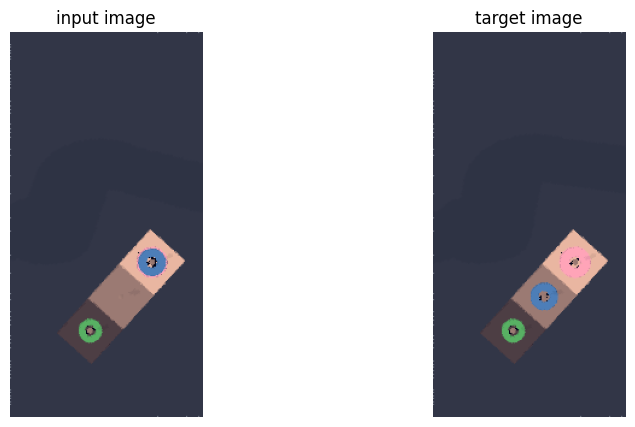

In [23]:
batch = get_random_batch(TESTSET_IDX[-2]+1)

img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')


original lang is (b'move the blue ring to the middle of the stand',)
Please input your lang ...
move the pink ring to the middle of the stand


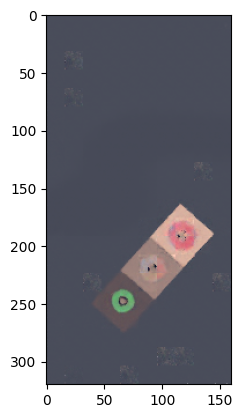

In [27]:
print(f"original lang is {lang}")
print("Please input your lang ...")
input_lang = input()
lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)

with torch.no_grad():
    
    loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)
